# Hackaton santé

In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
cols = ['PSP_SPE_SNDS', 'PRE_INS_REG', 'PRS_DEP_MNT', 'PRS_REM_BSE']
chunksize = 400000

In [73]:
regions = pd.read_excel("/home/p_paki/Documents/Kit DataScience/Lesson5/Lexique_open-DAMIR.xls", sheet_name="PRE_INS_REG", names=['PRE_INS_REG', 'label'])
specialites = pd.read_excel("/home/p_paki/Documents/Kit DataScience/Lesson5/Lexique_open-DAMIR.xls", sheet_name="PSP_SPE_SNDS", names=['PSP_SPE_SNDS', 'label'])

In [72]:
damir_iterator = pd.read_csv("/home/p_paki/Documents/Kit DataScience/Lesson5/A201712.csv", sep=';', usecols=cols, chunksize = chunksize)

In [74]:
nb_dep, nb, mt_dep, mt = 0, 0, 0, 0
info_reg, info_spec = pd.DataFrame(None, columns=['PRE_INS_REG']), pd.DataFrame(None, columns=['PSP_SPE_SNDS'])
for partition in damir_iterator:
    ok_partition = partition.loc[partition['PRS_REM_BSE'] > 0]
    value = ok_partition['PRS_DEP_MNT'].apply(lambda x : 1 if x>0 else 0)
    ok_partition = ok_partition.assign(IF_DEP=value.values)
    #general
    nb += ok_partition.shape[0]
    mt += np.sum(ok_partition['PRS_REM_BSE'])
    nb_dep += np.sum(ok_partition['PRS_DEP_MNT']>0)
    mt_dep += np.sum(ok_partition['PRS_DEP_MNT'])
    #region
    partition_reg = ok_partition.groupby(['PRE_INS_REG']).agg({'IF_DEP' : ['sum'], 'PRS_DEP_MNT': ['sum'], 'PRS_REM_BSE': ['count', 'sum']})
    try:
        info_reg = pd.concat([info_reg, partition_reg]).groupby(["PRE_INS_REG"], as_index=True).sum()
    except:
        info_reg = partition_reg if info_reg.empty else info_reg
    #specialite
    partition_spec = ok_partition.groupby(['PSP_SPE_SNDS']).agg({'IF_DEP' : ['sum'], 'PRS_DEP_MNT': ['sum'], 'PRS_REM_BSE': ['count', 'sum']})
    try:
        info_spec = pd.concat([info_spec, partition_spec]).groupby(["PSP_SPE_SNDS"], as_index=True).sum()
    except:
        info_spec = partition_spec if info_spec.empty else info_spec
info_reg.columns = info_reg.columns.map('_'.join).to_series()
info_spec.columns = info_spec.columns.map('_'.join).to_series()

In [77]:
info_reg['part_dep (%)'] = info_reg.apply(lambda x : round(x['IF_DEP_sum']/x['PRS_REM_BSE_count']*100,2), axis=1)
info_reg['ratio_dep (%)'] = info_reg.apply(lambda x : round(x['PRS_DEP_MNT_sum']/x['PRS_REM_BSE_sum']*100,2), axis=1)
info_reg.reset_index(inplace=True)
info_reg = pd.merge(info_reg, regions, on='PRE_INS_REG', how='left')

In [80]:
info_spec['part_dep (%)'] = info_spec.apply(lambda x : round(x['IF_DEP_sum']/x['PRS_REM_BSE_count']*100,2), axis=1)
info_spec['ratio_dep (%)'] = info_spec.apply(lambda x : round(x['PRS_DEP_MNT_sum']/x['PRS_REM_BSE_sum']*100,2), axis=1)
info_spec.reset_index(inplace=True)
info_spec = pd.merge(info_spec, specialites, on='PSP_SPE_SNDS', how='left')

### Résultats

In [78]:
print("Part de consultation avec dépassement :", round(nb_dep / nb * 100, 2), "%")
print("Part de montant de dépense liée au dépassement :", round(mt_dep / mt * 100, 2), "%")

Part de consultation avec dépassement : 6.29 %
Part de montant de dépense liée au dépassement : 8.29 %


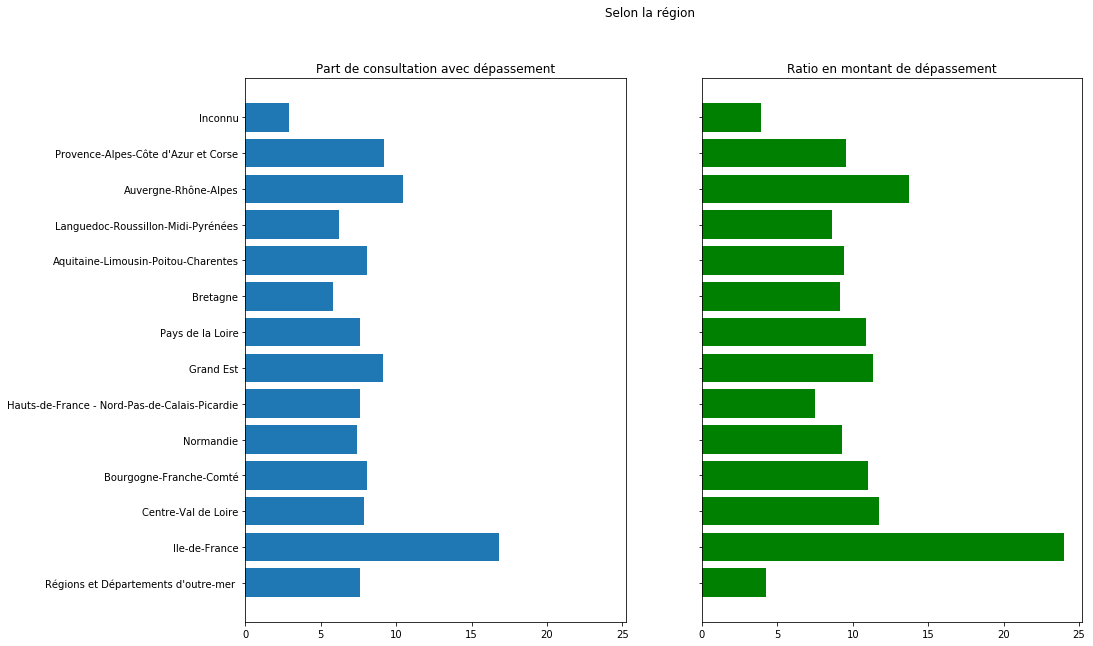

In [113]:
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(15, 10))
ax[0].barh(info_reg['label'], info_reg['part_dep (%)'])
ax[1].barh(info_reg['label'], info_reg['ratio_dep (%)'], color='green')
ax[0].title.set_text('Part de consultation avec dépassement')
ax[1].title.set_text('Ratio en montant de dépassement')
fig.suptitle('Selon la région');

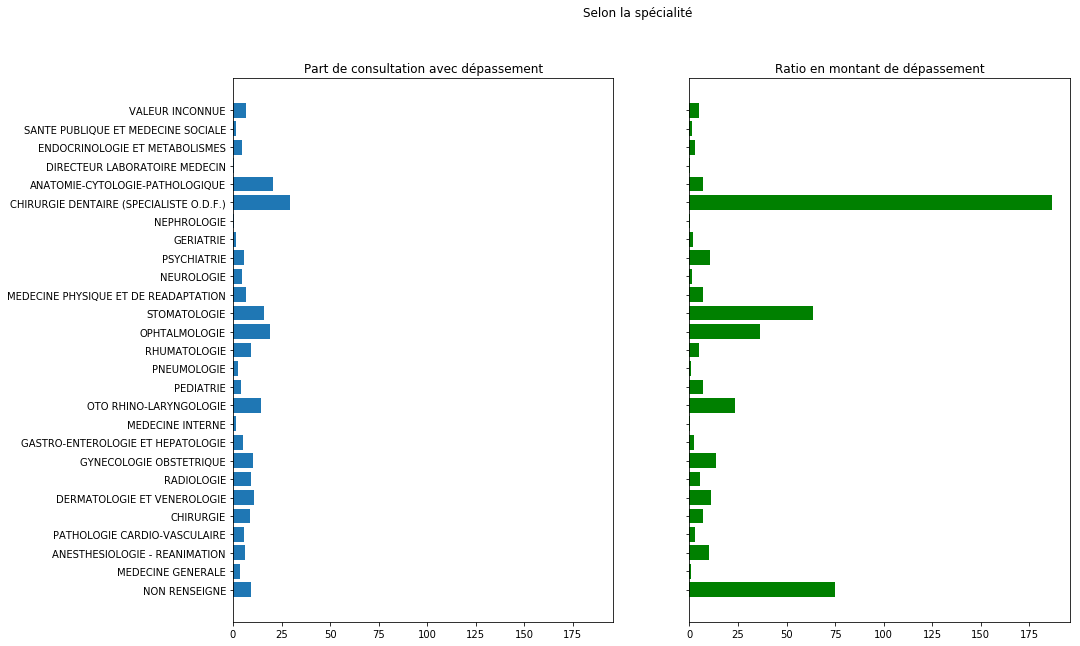

In [112]:
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(15, 10))
ax[0].barh(info_spec['label'], info_spec['part_dep (%)'])
ax[1].barh(info_spec['label'], info_spec['ratio_dep (%)'], color='green')
ax[0].title.set_text('Part de consultation avec dépassement')
ax[1].title.set_text('Ratio en montant de dépassement')
fig.suptitle('Selon la spécialité');